# Clustering
Let's figure out a distribution for all our documents to determine which documents are most out-of-distribution.

In [1]:
import glob

from data import load_data_file

all_docs = dict()

labels = [1] * 17 + [2] + [3] * 4 + [4] * 5

for filename in glob.glob("../data/GenBench/story/*") + glob.glob("../data/GenBench/advice/*") + glob.glob(
        "../data/GenBench/history/*") + glob.glob("../data/GenBench/personal/*"):
    doc = load_data_file(filename)
    all_docs[filename] = doc

print(f"Loaded {len(all_docs)} documents")

all_texts = [" ".join([sent.segmentation for sent in doc]).replace("-", " ") for doc in all_docs.values()]
all_texts

Loaded 27 documents


["o' sea x tok r ixóqiil ta' nada chi wi' ra r ichooch pwees ra jup ul jaa qe k'ark' aq jaa qe xe' juntiir rechaq galaan i' r ichooch aq juntiir qus i' juntiir qleen rechaq wi' j kwa'y aq wakix aq juntiir qleen rechaq i sik' r ch'elxik aq koom neen t r en re j pobre iil jun entoons re x tok r ixóqil kita' j q'unik t wer taq i kita' juntiir kita' qleen r ech aq i x en taq maq kirtyaan xe' j chaje j taq sik' wunaq jo' qa chaje j man kirtyaan li nen moo t wer laj r ichooch porke ta' k'ii qleen re ti q il ooj cha' che' man r ech'elxik jaan cha' xe' chaje j taq sik' kirtyaan i sik' wunaq t wer peech sik' ixóqil koom kita' j q'u' aq t r e saj r uuq sik' r ixóqil ti j koj chi r ij aq jilon li jilon li ti j q'a saaj j bida aq ch uch uleew i x saq er laj kaab' q'iij x iij sik' wunaq re sik' r ixóqil in b'e na abeer neen ch b' in te' re ti qa tij nojeel q'iij por ke si ta' in eel ta' nada qleen qe t' ok ich cha' sik' wunaq re entoons x b'iij sik' ánim re per iin ta' ch waaj t a chap alaaq' ta' c

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    max_features=8000,
)
tfidf.fit(all_texts)
tfidf_vectors = tfidf.transform(all_texts)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


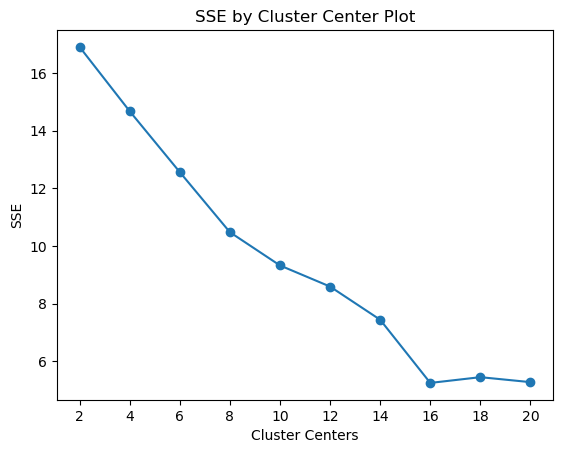

In [3]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k + 1, 2)

    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')


find_optimal_clusters(tfidf_vectors, 20)

In [4]:
clusters = MiniBatchKMeans(n_clusters=3, random_state=20).fit_predict(tfidf_vectors)

/Users/milesper/miniforge3/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


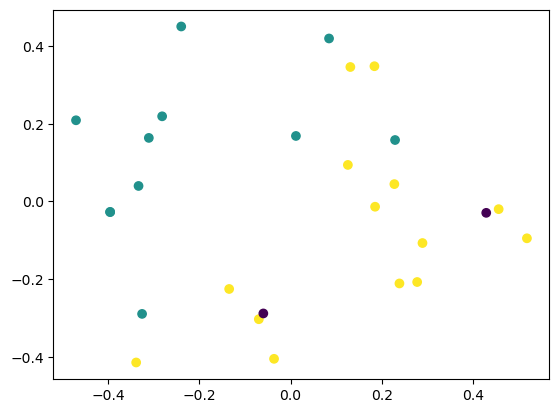

In [5]:
pca = PCA(n_components=2).fit_transform(tfidf_vectors.todense())

plt.scatter(pca[:, 0], pca[:, 1], c=clusters)

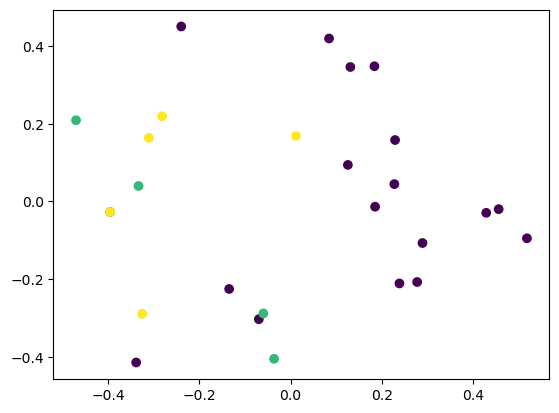

In [6]:
plt.scatter(pca[:, 0], pca[:, 1], c=labels)

../data/GenBench/story/14.txt:	138/3508=0.03933865450399088 unique tokens
../data/GenBench/story/16.txt:	90/3455=0.02604920405209841 unique tokens
../data/GenBench/story/63.txt:	183/5271=0.03471826977803073 unique tokens
../data/GenBench/story/49.txt:	74/1801=0.041088284286507494 unique tokens
../data/GenBench/story/59.txt:	246/4121=0.05969424896869692 unique tokens
../data/GenBench/story/72.txt:	17/500=0.034 unique tokens
../data/GenBench/story/57.txt:	25/1406=0.017780938833570414 unique tokens
../data/GenBench/story/56.txt:	70/1967=0.03558718861209965 unique tokens
../data/GenBench/story/54.txt:	112/3066=0.0365296803652968 unique tokens
../data/GenBench/story/55.txt:	61/1526=0.0399737876802097 unique tokens
../data/GenBench/story/2.txt:	62/2275=0.027252747252747254 unique tokens
../data/GenBench/story/52.txt:	23/1174=0.019591141396933562 unique tokens
../data/GenBench/story/35.txt:	93/4855=0.019155509783728115 unique tokens
../data/GenBench/story/37.txt:	113/3961=0.028528149457207774

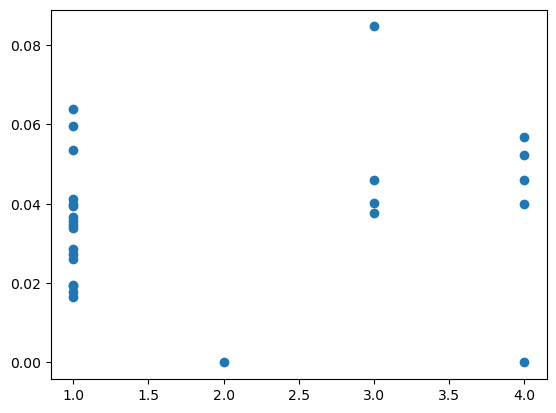

In [7]:
def all_tokens(doc):
    return [token for line in doc for token in line.morphemes()]


unique_token_rates = []

for key, doc in all_docs.items():
    # Check what percent of the morphemes in the doc are unknown
    doc_tokens = all_tokens(doc)
    other_tokens = [all_tokens(d) for k, d in all_docs.items() if k != key]
    other_tokens = [token for other_doc_tokens in other_tokens for token in other_doc_tokens]

    num_unique_tokens = len([token for token in doc_tokens if token not in other_tokens])
    print(f"{key}:\t{num_unique_tokens}/{len(doc_tokens)}={num_unique_tokens / len(doc_tokens)} unique tokens")
    unique_token_rates.append(num_unique_tokens / len(doc_tokens))

plt.scatter(labels, unique_token_rates)

Looks like class 3 (advice) has the most unique tokens, we'll use that as an eval set

In [8]:
advice = load_data_file("../data/GenBench/advice")
story = load_data_file("../data/GenBench/story")
history = load_data_file("../data/GenBench/history")
personal = load_data_file("../data/GenBench/personal")

all_classes = {
    "advice": advice,
    "story": story,
    "history": history,
    "personal": personal
}

for key, doc in all_classes.items():
    # Check what percent of the morphemes in the doc are unknown
    doc_tokens = all_tokens(doc)
    other_tokens = [all_tokens(d) for k, d in all_classes.items() if k != key]
    other_tokens = [token for other_doc_tokens in other_tokens for token in other_doc_tokens]

    num_unique_tokens = len([token for token in doc_tokens if token not in other_tokens])
    print(f"{key}:\t{num_unique_tokens}/{len(doc_tokens)}={num_unique_tokens / len(doc_tokens)} unique tokens")
    unique_token_rates.append(num_unique_tokens / len(doc_tokens))

advice:	0/6347=0.0 unique tokens
story:	2903/51234=0.05666159191162119 unique tokens
history:	567/12626=0.04490733407254871 unique tokens
personal:	1659/36126=0.04592260421856834 unique tokens


In [9]:
len(history)

1334

In [14]:
story = load_data_file("../data/GenBench/story_personal")
nonstory = load_data_file("../data/GenBench/nonstory")

story_tokens = all_tokens(story)
nonstory_tokens = all_tokens(nonstory)

print(f"Loaded train set with {len(story_tokens)} tokens and eval set with {len(nonstory_tokens)} tokens")

unseen_tokens = len([token for token in nonstory_tokens if token not in story_tokens])

print(f"{unseen_tokens}/{len(nonstory_tokens)}={unseen_tokens / len(nonstory_tokens)}")

Loaded train set with 93707 tokens and eval set with 12626 tokens
567/12626=0.04490733407254871
